In [1]:
import cv2
from ultralytics import YOLO
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image, ImageEnhance
import albumentations as A

In [2]:
image_path = 'image/Task1.jpeg'
image = cv2.imread(image_path)

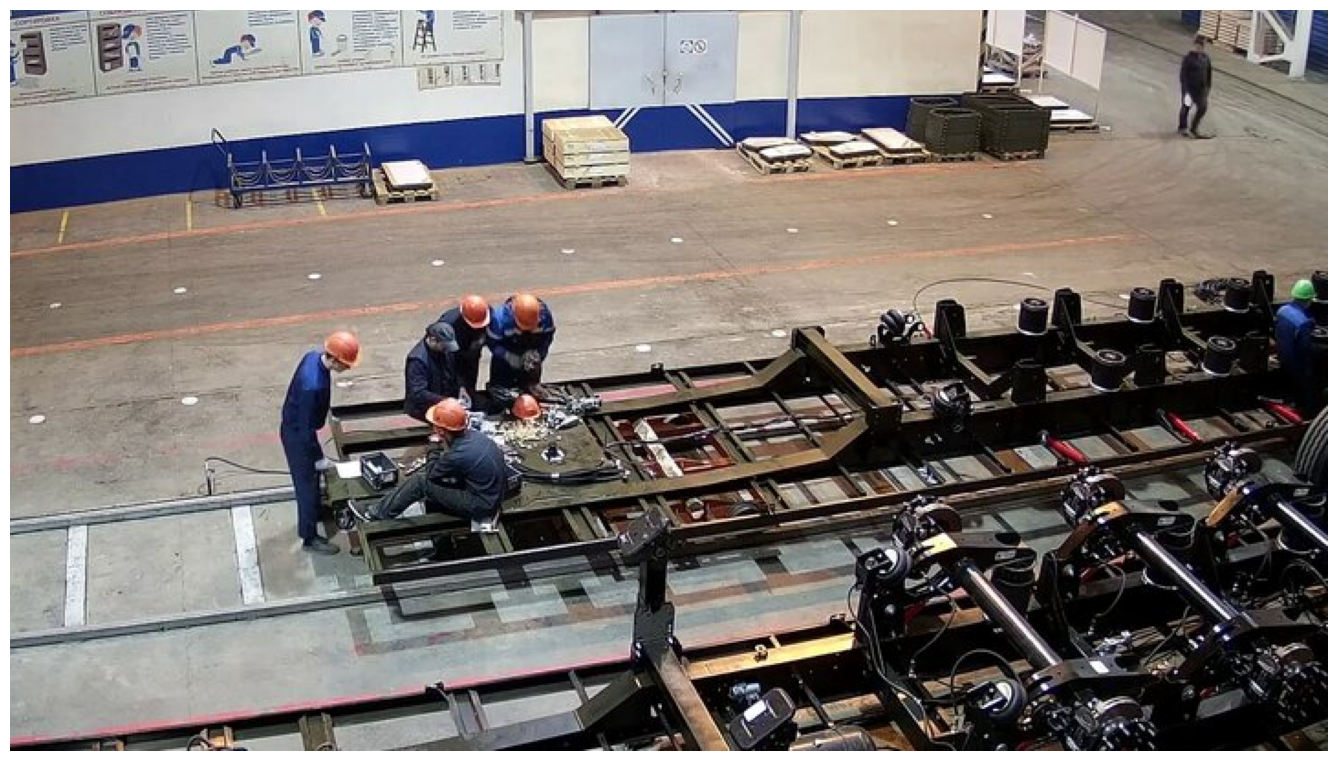

In [3]:
plt.figure(figsize=(17,11))
plt.imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

In [4]:
model = YOLO('yolov10x.pt')

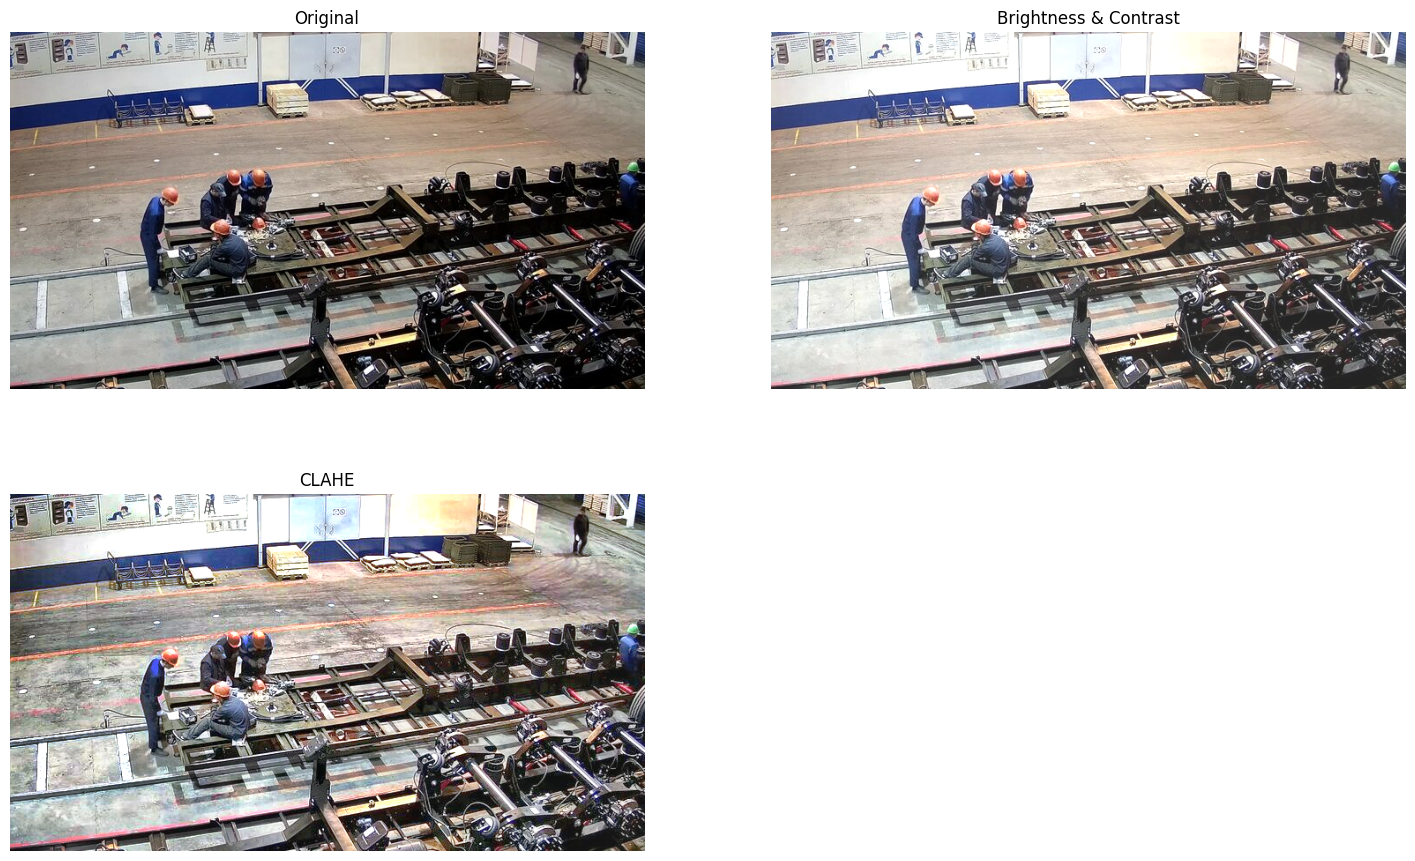

False

In [5]:

# Увеличение яркости и контраста
alpha = 1.1 
beta =  35  
bright_contrast_image = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)

# Применение CLAHE
clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
clahe_image = np.zeros_like(bright_contrast_image)
for i in range(3):
    clahe_image[:, :, i] = clahe.apply(bright_contrast_image[:, :, i])

# # Применение фильтра Собеля на каждом канале отдельно
# sobel_image = np.zeros_like(bright_contrast_image)
# ksize = 3  # Размер ядра (1, 3, 5, 7)
# for i in range(3):
#     sobelx = cv2.Sobel(image[:, :, i], cv2.CV_64F, 1, 0, ksize=ksize)
#     sobely = cv2.Sobel(image[:, :, i], cv2.CV_64F, 0, 1, ksize=ksize)
#     sobel = cv2.magnitude(sobelx, sobely)
#     sobel = cv2.normalize(sobel, None, 0, 255, cv2.NORM_MINMAX)
#     sobel_image[:, :, i] = np.uint8(sobel)

# # Применение адаптивного порогового значения на каждом канале отдельно
# adaptive_thresh_image = np.zeros_like(image)
# blockSize = 39 # Размер области (нечетное число)
# C = 5         # Константа (меньше для более темного результата)
# for i in range(3):
#     adaptive_thresh_image[:, :, i] = cv2.adaptiveThreshold(image[:, :, i], 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
#                                                            cv2.THRESH_BINARY_INV, blockSize, C)

# Визуализация результатов
plt.figure(figsize=(18, 11))
plt.subplot(2, 2, 1), plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)), plt.title('Original'), plt.axis("off")
plt.subplot(2, 2, 2), plt.imshow(cv2.cvtColor(bright_contrast_image, cv2.COLOR_BGR2RGB)), plt.title('Brightness & Contrast'), plt.axis("off")
plt.subplot(2, 2, 3), plt.imshow(cv2.cvtColor(clahe_image, cv2.COLOR_BGR2RGB)), plt.title('CLAHE'), plt.axis("off")

# plt.subplot(2, 3, 4), plt.imshow(cv2.cvtColor(sobel_image, cv2.COLOR_BGR2RGB)), plt.title('Sobel')
# plt.subplot(2, 3, 5), plt.imshow(cv2.cvtColor(adaptive_thresh_image, cv2.COLOR_BGR2RGB)), plt.title('Adaptive Threshold')

# plt.tight_layout()
plt.show()


cv2.imwrite('/mnt/data/enhanced_clahe.jpg', clahe_image)
cv2.imwrite('/mnt/data/enhanced_brightness_contrast.jpg', bright_contrast_image)
# cv2.imwrite('/mnt/data/enhanced_sobel.jpg', sobel_image)
# cv2.imwrite('/mnt/data/enhanced_adaptive_thresh.jpg', adaptive_thresh_image)

In [6]:
detects = model(clahe_image)


0: 384x640 7 persons, 58.9ms
Speed: 11.1ms preprocess, 58.9ms inference, 123.4ms postprocess per image at shape (1, 3, 384, 640)


In [7]:
count_people = 0
for Clc in detects[0].boxes.cls:
    if Clc == 0:
        count_people += 1
count_people

7

In [8]:
annotated_image = detects[0].plot()
cv2.putText(annotated_image, f'People: {count_people}', (15, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 4)
cv2.imwrite('output.jpg', annotated_image)
imageOutput = cv2.imread('output.jpg')
plt.figure(figsize=(22,9))
plt.imshow(cv2.cvtColor(imageOutput,cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

In [9]:
detects[0].boxes.xyxy

tensor([[146.3180, 174.0217, 192.2644, 298.3582],
        [637.4223,  13.9800, 657.5977,  70.9511],
        [182.1324, 213.0123, 271.9966, 285.2029],
        [214.3217, 170.8443, 252.7832, 227.1374],
        [690.3593, 146.2768, 719.0953, 220.2216],
        [258.6857, 154.3100, 298.8792, 219.9565],
        [232.0732, 155.8448, 262.9237, 211.5083]], device='cuda:0')

In [10]:
def calculate_distance(center1, center2):
    cx1, cy1 = center1
    cx2, cy2 = center2
    distance = ((cx2 - cx1)**2 + (cy2 - cy1)**2)**0.5
    return distance

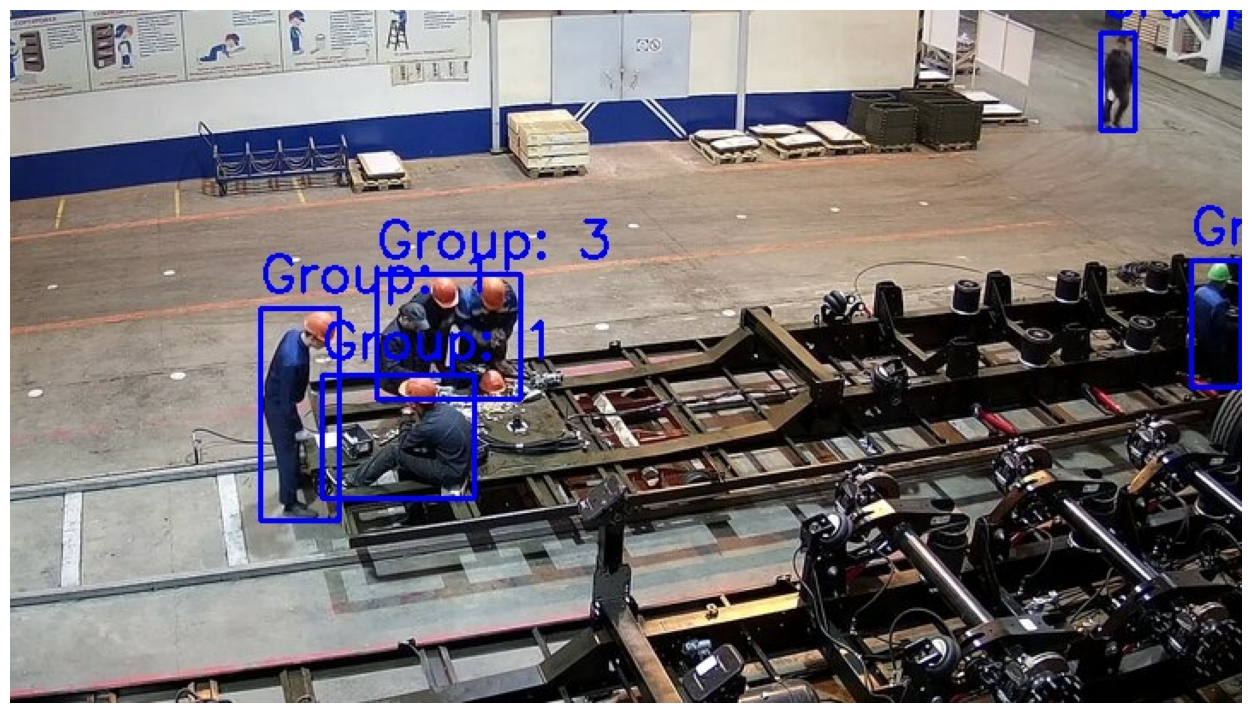

In [21]:
boxes = detects[0].boxes.xyxy  #(x_min, y_min, x_max, y_max)
centers = [[(boxes[i][0] + boxes[i][2]), (boxes[i][1] + boxes[i][3])]  for i in range(len(boxes))]
groups = []
box_group_num = [-1] * len(boxes)

def dfs(v,  num):
    box_group_num[v] = num
    for u in range(len(boxes)):
        if (v != u and box_group_num[u] == -1 and calculate_distance(centers[v], centers[u]) < 100):
            dfs(u, num)
num = 0
for u in range(len(boxes)):
    if (box_group_num[u] == -1):
            dfs(u, num)
            num += 1
for curNum in range(num):
    current_group = []
    for i in range(len(boxes)):
        if box_group_num[i] == curNum:
            current_group.append(i)
    groups.append(current_group)



# Нарисовать прямоугольники для каждой группы и добавить текст с количеством людей в группе
annotated_image = image.copy()
for group in groups:
    group_boxes = [boxes[idx] for idx in group]
    num_people = len(group)
    # Находим общий прямоугольник для текущей группы
    x_min = min([box[0] for box in group_boxes])
    y_min = min([box[1] for box in group_boxes])
    x_max = max([box[2] for box in group_boxes])
    y_max = max([box[3] for box in group_boxes])
    # Рисуем прямоугольник и добавляем текст
    cv2.rectangle(annotated_image, (int(x_min), int(y_min)), (int(x_max), int(y_max)), (255, 0, 0), 2)
    cv2.putText(annotated_image, f'Group: {num_people}', (int(x_min), int(y_min) - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)

# Сохранить или показать изображение с результатами
cv2.imwrite('output.jpg', annotated_image)
imageOutput = cv2.imread('output.jpg')
plt.figure(figsize=(22, 9))
plt.imshow(cv2.cvtColor(imageOutput, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()